<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Jacobi method

## Contents

In this notebook, we will learn

- How to parallelize the Jacobi method
- How the data partition can impact the performance of a distributed algorithm
- How to use latency hiding to improve parallel performance



<div class="alert alert-block alert-info">
<b>Note:</b> Do not forget to run the next cell before you start studying this notebook. 
</div>

In [ ]:
using Printf

function answer_checker(answer,solution)
    if answer == solution
        "🥳 Well done! "
    else
        "It's not correct. Keep trying! 💪"
    end |> println
end
gauss_seidel_1_check(answer) = answer_checker(answer,"c")
jacobi_1_check(answer) = answer_checker(answer, "d")
jacobi_2_check(answer) = answer_checker(answer, "b")
jacobi_3_check(answer) = answer_checker(answer, "c")
lh_check(answer) = answer_checker(answer, "c")
sndrcv_check(answer) = answer_checker(answer,"b")
function partition_1d_answer(bool)
    bool || return
    msg = """
- We update N^2/P items per iteration
- We need data from 2 neighbors (2 messages per iteration)
- We communicate N items per message
- Communication/computation ratio is 2N/(N^2/P) = 2P/N =O(P/N)
    """
    println(msg)
end
function partition_2d_answer(bool)
        bool || return
    msg = """
- We update N^2/P items per iteration
- We need data from 4 neighbors (4 messages per iteration)
- We communicate N/sqrt(P) items per message
- Communication/computation ratio is (4N/sqrt(P)/(N^2/P)= 4sqrt(P)/N =O(sqrt(P)/N)
    """
    println(msg)
end
function partition_cyclic_answer(bool)
        bool || return
    msg = """
- We update N^2/P items
- We need data from 4 neighbors (4 messages per iteration)
- We communicate N^2/P items per message (the full data owned by the neighbor)
- Communication/computation ratio is O(1)
    """
println(msg)
end
function sndrcv_fix_answer(bool)
        bool || return
    msg = """
    One needs to carefully order the sends and the receives to avoid cyclic dependencies
    that might result in deadlocks. The actual implementation is left as an exercise.   
    """
    println(msg)
end
jacobitest_check(answer) = answer_checker(answer,"a")
function jacobitest_why(bool)
        bool || return
    msg = """
    The test will pass. The parallel implementation does exactly the same operations
    in exactly the same order than the sequential one. Thus, the result should be
    exactly the same. Note however this is often not true in other parallel algorithms.
    Specially, when one does parallel reductions.
    """
    println(msg)
end
gauss_seidel_2_check(answer) = answer_checker(answer,"d")
function gauss_seidel_2_why(bool)
        bool || return
    msg = """
    All "red" cells can be updated in parallel as they only depend on the values of "black" cells.
    In order workds, we can update the "red" cells in any order whithout changing the result. They only
    depend on values in the "black" cells, which will not change during the loop over "red" cells.
    Similarly, all "black" cells can be updated in parallel as they only depend on "red" cells.
    """
    println(msg)
end
println("🥳 Well done! ")

## The Jacobi method for the Laplace equation


The [Jacobi method](https://en.wikipedia.org/wiki/Jacobi_method) is a numerical tool to solve systems of linear algebraic equations. One of the main applications of the Jacobi method is to solve the equations resulting from boundary value problems (BVPs). I.e., given the values at the boundary (of a grid), we are interested in finding the interior values that fulfill a certain equation.



<div>
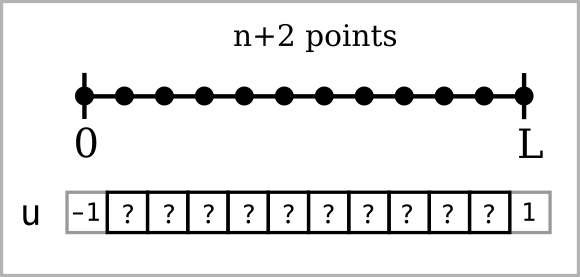
</div>

When solving a [Laplace equation](https://en.wikipedia.org/wiki/Laplace%27s_equation) in 1D, the Jacobi method leads to the following iterative scheme: The entry $i$ of vector $u$ at iteration $t+1$ is computed as:

$u^{t+1}_i = \dfrac{u^t_{i-1}+u^t_{i+1}}{2}$


This algorithm is yet simple but shares fundamental challenges with many other algorithms used in scientific computing. This is why we are studying it here.


### Serial implementation

The following code implements the iterative scheme above for boundary conditions -1 and 1 on a grid with $n$ interior points.

<div class="alert alert-block alert-info">
<b>Note:</b> `u, u_new = u_new, u` is equivalent to `tmp = u; u = u_new; u_new = tmp`. I.e. we swap the arrays `u` and `u_new` are referring to. 
</div>



In [ ]:
function jacobi(n,niters)
    u = zeros(n+2)
    u[1] = -1
    u[end] = 1
    u_new = copy(u)
    for t in 1:niters
        for i in 2:(n+1)
            u_new[i] = 0.5*(u[i-1]+u[i+1])
        end
        u, u_new = u_new, u
    end
    u
end

If you run it for zero iterations, we will see the initial condition.

In [ ]:
jacobi(5,0)

If you run it for enough iterations, you will see the expected solution of the Laplace equation: values that vary linearly form -1 to 1.

In [ ]:
jacobi(5,100)

In our version of the Jacobi method, we return after a given number of iterations. Other stopping criteria are possible. For instance, iterate until the maximum difference between u and u_new (in absolute value) is below a tolerance.

In [ ]:
function jacobi_with_tol(n,tol)
    u = zeros(n+2)
    u[1] = -1
    u[end] = 1
    u_new = copy(u)
    while true
        diff = 0.0
        for i in 2:(n+1)
            ui_new = 0.5*(u[i-1]+u[i+1])
            u_new[i] = ui_new
            diff_i = abs(ui_new-u[i])
            diff = max(diff_i,diff)            
        end
        if diff < tol
            return u_new
        end
        u, u_new = u_new, u
    end
    u
end

In [ ]:
n = 5
tol = 1e-10
jacobi_with_tol(n,tol)

However, we are not going to parallelize this more complex in this notebook (left as an exercise). The simpler one is already challenging enough to start with.

## Parallelization of the Jacobi method

Now, let us parallelize the Jacobi method.


### Where can we exploit parallelism?

Look at the two nested loops in the sequential implementation:

```julia
for t in 1:nsteps
    for i in 2:(n+1)
        u_new[i] = 0.5*(u[i-1]+u[i+1])
    end
    u, u_new = u_new, u
end
```

- The outer loop over `t` cannot be parallelized. The value of `u` at step `t+1` depends on the value at the previous step `t`.
- The inner loop is trivially parallel. The loop iterations are independent (any order is possible).



### Parallelization strategy

Remember that a sufficiently large grain size is needed to achieve performance in a distributed algorithm. For Jacobi, one could update each entry of vector `u_new` in a different process, but this would not be efficient. Instead, we use a parallelization strategy with a larger grain size that is analogous to the algorithm 3 we studied for the matrix-matrix multiplication:

- Data partition: each worker updates a consecutive section of the array `u_new` 

The following figure displays the data distribution over 3 processes.

<div>
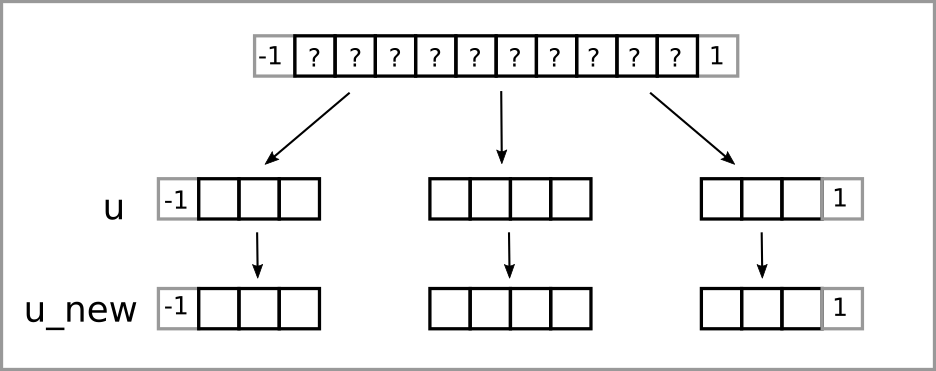
</div>
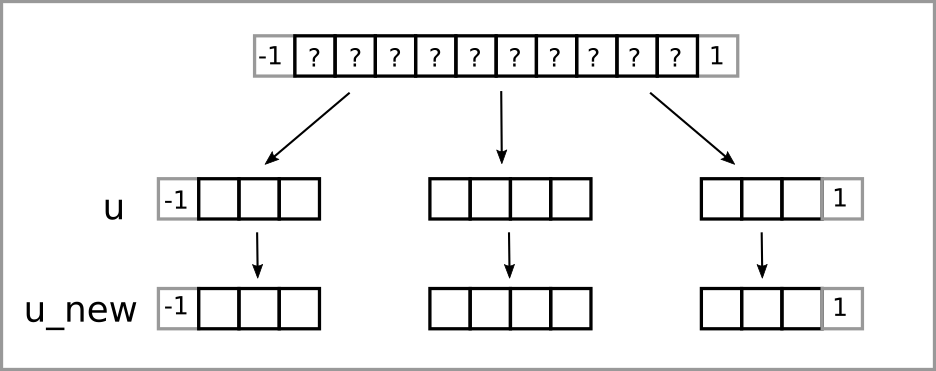

### Data dependencies

Recall the Jacobi update:

`u_new[i] = 0.5*(u[i-1]+u[i+1])`

Note that an entry in the interior of the locally stored vector can be updated using local data  only. For updating this one, communication is not needed.

<div>
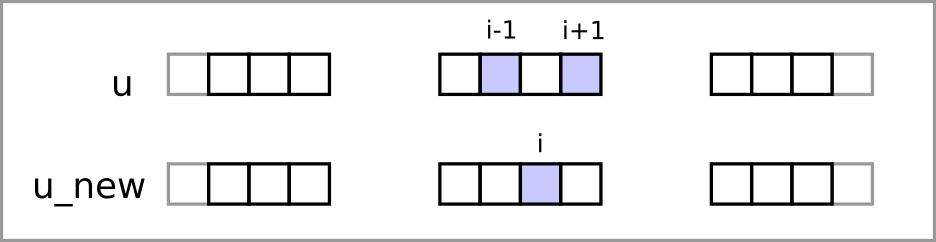
</div>
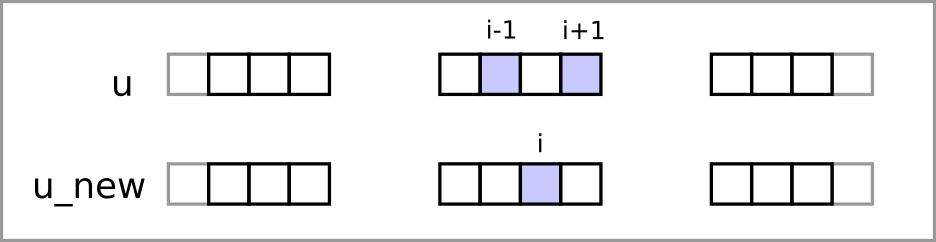

However, to update the entries on the boundary of the locally stored vector we need entries stored on other processors.

<div>
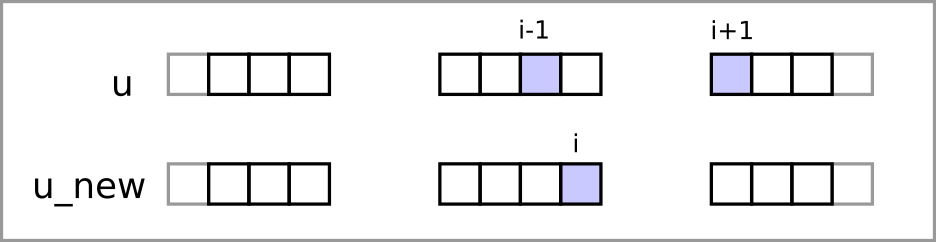
</div>
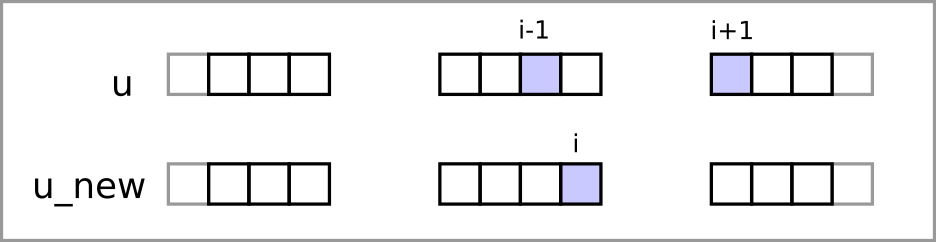

Thus, in order to update the local entries in `u_new`, we also need  some remote entries of vector `u` located in neighboring processes. Figure below shows the entries of `u` needed to update the local entries of `u_new` in a particular process (CPU 2).

<div>
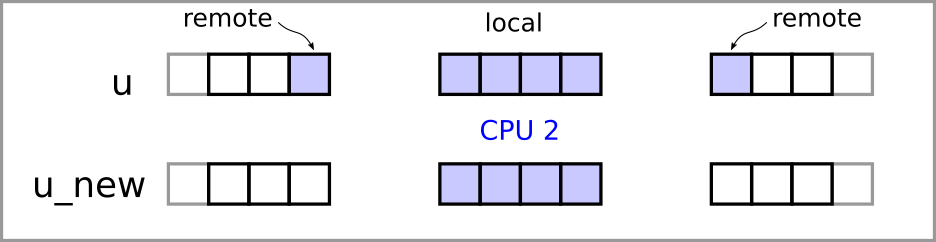
</div>
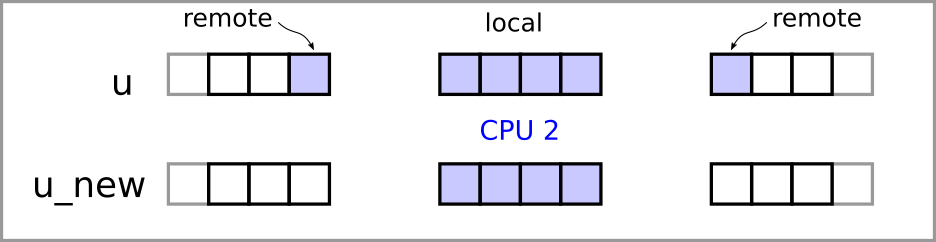

### Communication overhead

Now that we understand which are the data dependencies, we can do the theoretical performance analysis.


- We update $N/P$ entries in each process at each iteration, where $N$ is the total length of the vector and $P$ the number of processes
- Thus, computation complexity is $O(N/P)$
- We need to get remote entries from 2 neighbors (2 messages per iteration)
- We need to communicate 1 entry per message
- Thus, communication complexity is $O(1)$
- Communication/computation ratio is $O(P/N)$, making the algorithm potentially scalable if $P<<N$.


### Ghost (aka halo) cells

This parallel strategy is efficient according to the theoretical analysis. But how to implement it? A usual way of implementing the Jacobi method and related algorithms is using so-called ghost cells. Ghost cells represent the missing data dependencies in the data owned by each process. After importing the appropriate values from the neighbor processes one can perform the usual sequential Jacobi update locally in the processes. Cells with gray edges are ghost (or boundary) cells in the following figure. Note that we added one ghost cell at the front and end of the local array.

<div>
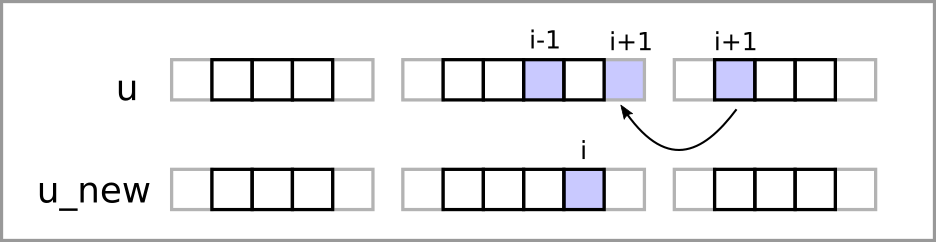
</div>
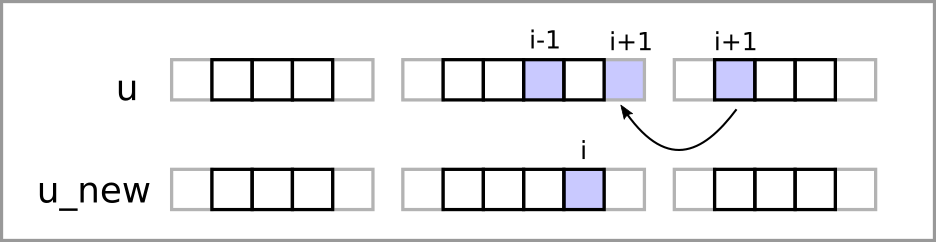

Thus, the algorithm is usually implemented following two main phases at each iteration Jacobi:

1. Fill the ghost entries with communications
2. Do the Jacobi update sequentially at each process

<div>
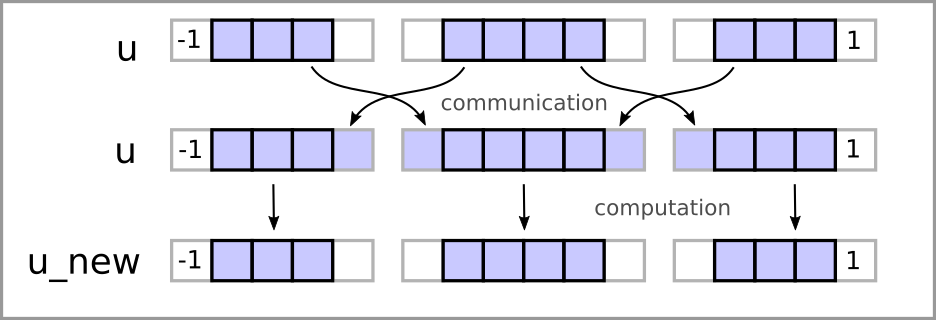
</div>
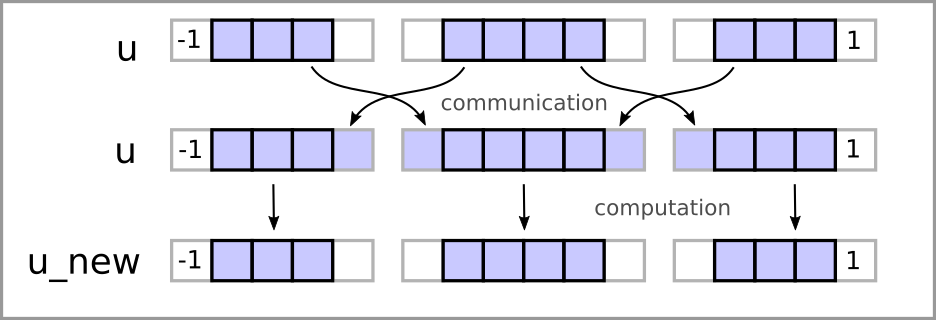

We are going to implement this algorithm with MPI later in this notebook.

## Extension to 2D


The Jacobi method studied so far was for a one dimensional Laplace equation. In real-world applications however, one solve equations in multiple dimensions. Typically 2D and 3D. The 2D and 3D cases are conceptually equivalent, but we will discuss the 2D case here for simplicity.

Now, the goal is to find the interior points of a 2D grid given the values at the boundary.



<div>
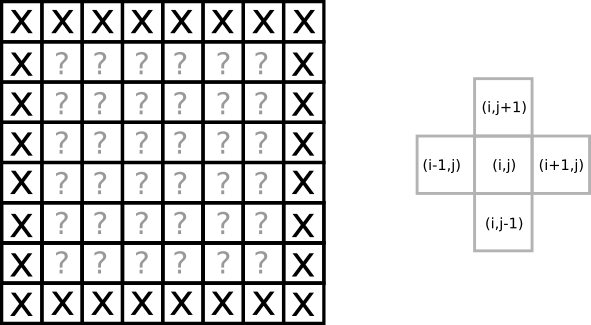
</div>
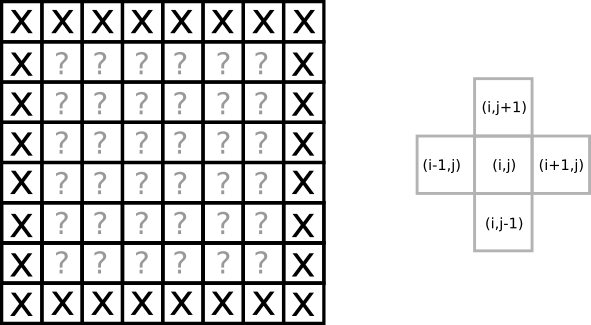

For the Laplace equation in 2D, the interior values in the computational grid (represented by a matrix $u$) are computed with this iterative scheme. The entry $(i,j)$ of  matrix $u$ at iteration $t+1$ is computed as:


$u^{t+1}_{(i,j)} = \dfrac{u^t_{(i-1,j)}+u^t_{(i+1,j)}+u^t_{(i,j-1)}+u^t_{(i,j+1)}}{4}$

Note that each entry is updated as the average of the four neighbors (top,bottom,left,right) of that entry in the previous iteration. 

### Serial implementation

The next code implements a simple example, where the boundary values are equal to 1.

In [ ]:
function jacobi_2d(n,niters)
    u = zeros(n+2,n+2)
    u[1,:] = u[end,:] = u[:,1] = u[:,end] .= 1
    u_new = copy(u)
    for t in 1:niters
        for j in 2:(n+1)
            for i in 2:(n+1)
                north = u[i,j+1]
                south = u[i,j-1]
                east = u[i+1,j]
                west = u[i-1,j]
                u_new[i,j] = 0.25*(north+south+east+west)
            end
        end
        u, u_new = u_new, u
    end
    u
end

If you run the function for zero iterations you will see the initial condition.

In [ ]:
n = 10
niters = 0
u = jacobi_2d(n,niters)

If you run the problem for enough iterations, you should converge to the exact solution. In this case, the exact solution is a matrix with all values equal to one.

In [ ]:
n = 10
niters = 300
u = jacobi_2d(n,niters)

### Where can we exploit parallelism?

```julia
for t in 1:niters
    for j in 2:(n+1)
        for i in 2:(n+1)
            north = u[i,j+1]
            south = u[i,j-1]
            east = u[i+1,j]
            west = u[i-1,j]
            u_new[i,j] = 0.25*(north+south+east+west)
        end
    end
    u, u_new = u_new, u
end
```

- The outer loop cannot be parallelized (like in the 1D case). 
- The two inner loops are trivially parallel


### Parallelization strategies

In 2D, one has more flexibility in order to distribute the data over the processes. We consider these three alternatives:

- 1D block row partition (each worker handles a subset of consecutive rows and all columns)
- 2D block partition (each worker handles a subset of consecutive rows and columns)
- 2D cyclic partition (each workers handles a subset of alternating rows ans columns)



<div class="alert alert-block alert-info">
<b>Note:</b> Other options are 1D block column partition and 1D cyclic (row or column) partition. They are not analyzed in this notebook since they are closely related to the other strategies. In Julia, in fact, it is often preferable to work with 1D block column partitions than with 1D block row partitions since matrices are stored in column major order.
</div>


The three partition types are depicted in the following figure for 4 processes.

<div>
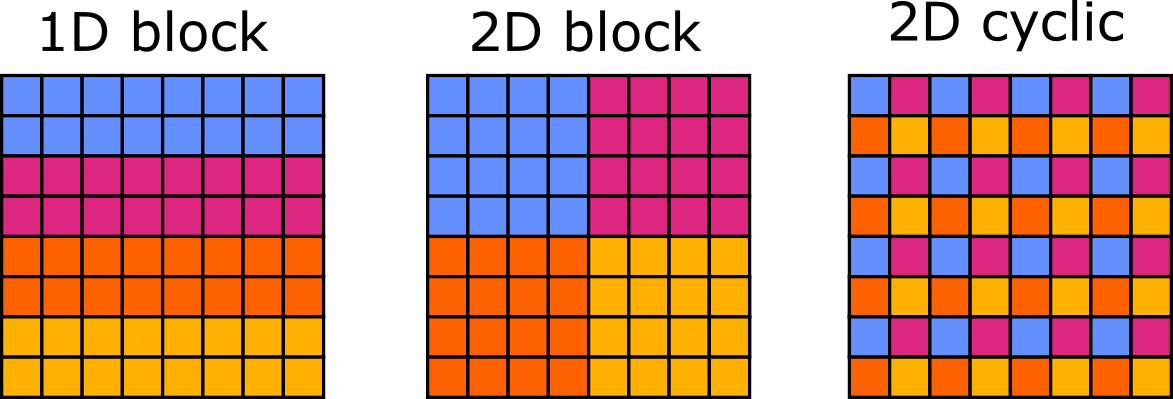
</div>
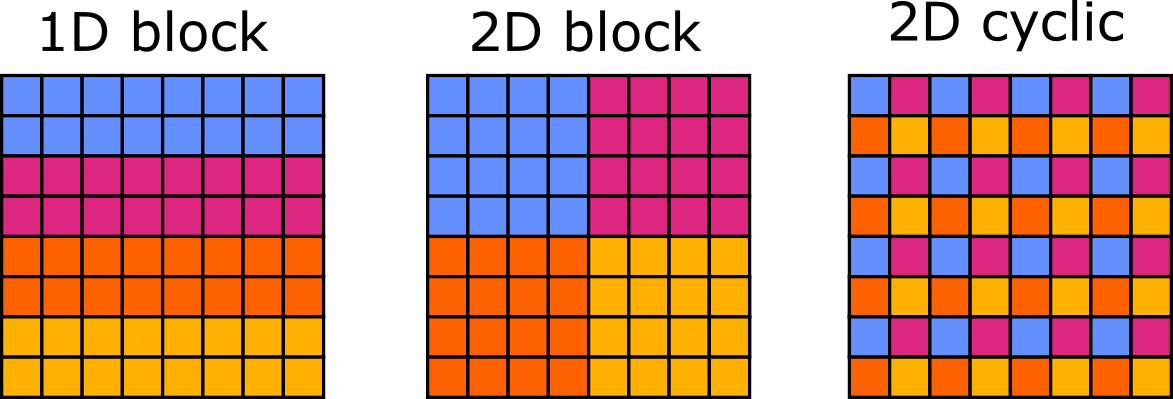

Which of the thee alternatives is more efficient? To answer this question we need to quantify how much data is processed and communicated in each case. The following analysis assumes that the grid is of $N$ by $N$ cells and that the number of processes is $P$.

### 1D block partition

The following figure shows the portion of vector `u_new` that is updated at each iteration by a particular process (CPU 3) left picture, and which entries of `u` are needed to update this data, right picture. We use analogous figures for the other partitions below.


<div>
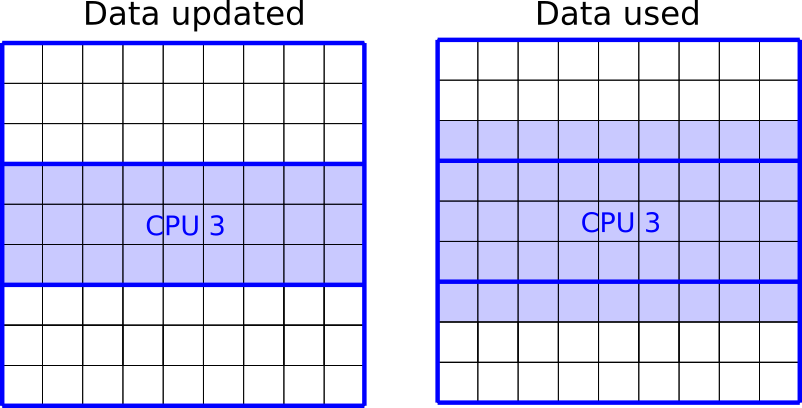
</div>
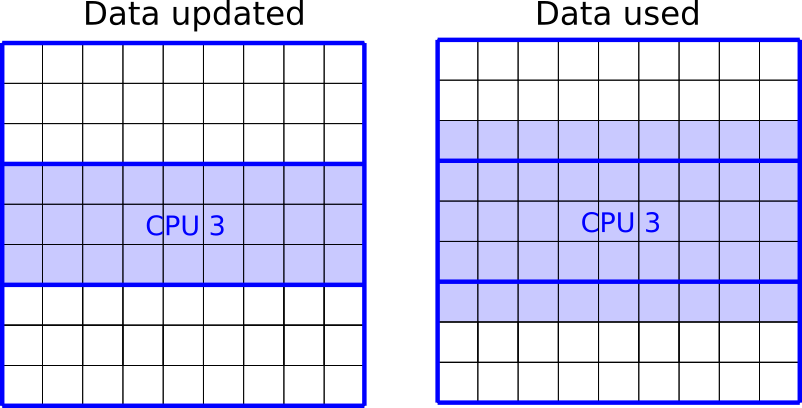

<div class="alert alert-block alert-success">
<b>Question:</b>  Compute the complexity of the communication over computation ratio for this data partition.
</div>

In [ ]:
uncover = false # Change to true to see the answer
partition_1d_answer(uncover)

### 2D block partition

<div>
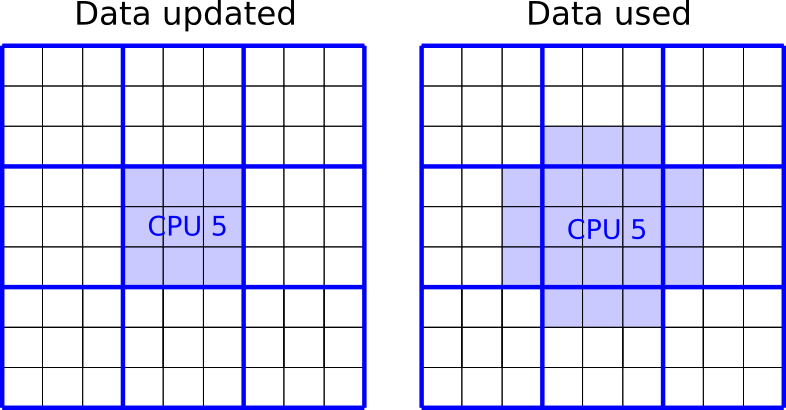
</div>

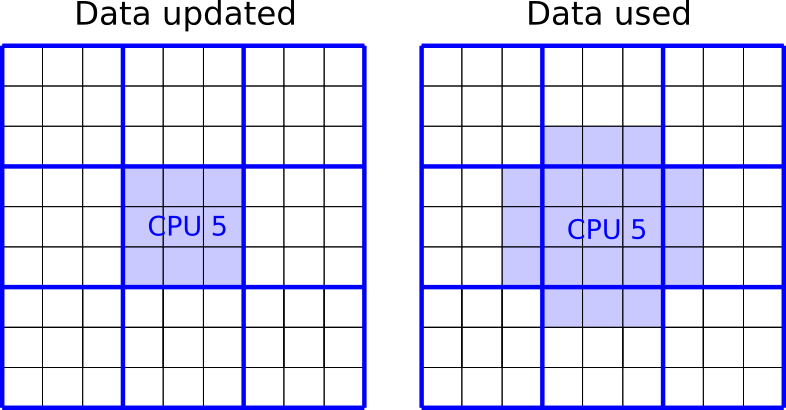

<div class="alert alert-block alert-success">
<b>Question:</b>  Compute the complexity of the communication over computation ratio for this data partition.
</div>

In [ ]:
uncover = false
partition_2d_answer(uncover)

### 2D cyclic partition

<div>
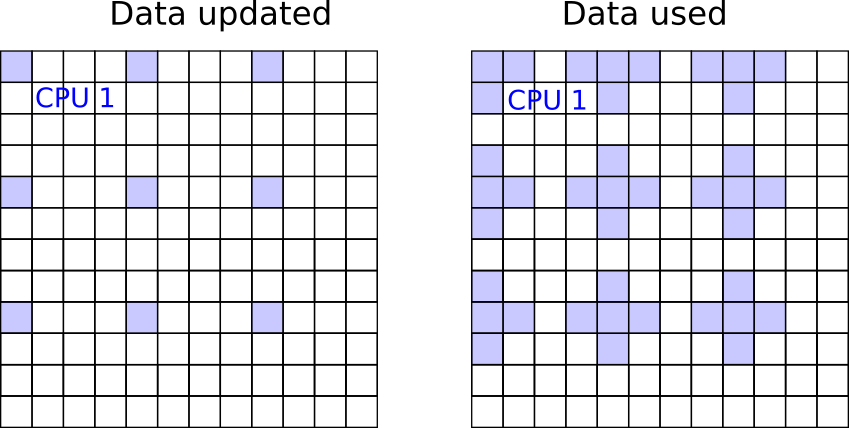
</div>
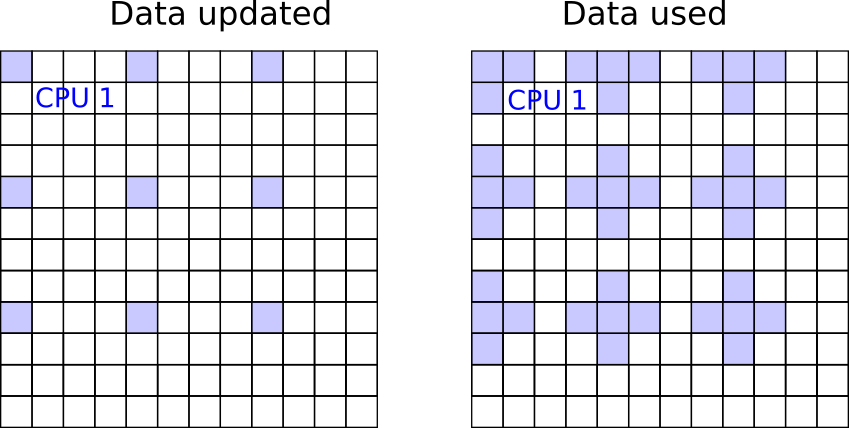

<div class="alert alert-block alert-success">
<b>Question:</b>  Compute the complexity of the communication over computation ratio for this data partition.
</div>

In [ ]:
uncover = false
partition_cyclic_answer(uncover)

### Summary

|Partition | Messages <br> per iteration | Communication <br>per worker | Computation <br>per worker | Ratio communication/<br>computation |
|---|---|---|---|---|
| 1D block | 2 | O(N) | N²/P | O(P/N) |
| 2D block | 4 | O(N/√P) | N²/P | O(√P/N) |
| 2D cyclic | 4 |O(N²/P) | N²/P | O(1) |

### Which partition is the best one?



- Both 1D and 2D block partitions are potentially scalable if $P<<N$
- The 2D block partition has the lowest communication complexity
- The 1D block partition requires to send less messages (It can be useful if the fixed cost of sending a message is high)
- The best strategy for a given problem size will thus depend on the machine.
- Cyclic partitions are impractical for this application (but they are useful in others) 



## The Gauss-Seidel method 

Now let us study a slightly more challenging method. The implementation of Jacobi used an auxiliary array `u_new`. The usage of `u_new` seems a bit unnecessary at first sight, right? If we remove it, we get another method called Gauss-Seidel.


The following cell contains the sequential implementation of Gauss-Seidel. It is obtained taking the sequential implementation of Jacobi, removing `u_new`, and only using `u`. This method is more efficient in terms of memory consumed (only one vector required instead of two). However it is harder to parallelize.

In [ ]:
function gauss_seidel(n,niters)
    u = zeros(n+2)
    u[1] = -1
    u[end] = 1
    for t in 1:niters
        for i in 2:(n+1)
            u[i] = 0.5*(u[i-1]+u[i+1])
        end
    end
    u
end

Note that the final solution is nearly the same as for Jacobi for a large enough number of iterations.

In [ ]:
n = 5
niters = 1000
gauss_seidel(n,niters)

In [ ]:
jacobi(n,niters)

<div class="alert alert-block alert-success">
<b>Question:</b>  Which of the two loops in the Gauss-Seidel method are trivially parallelizable?
</div>

```julia
for t in 1:niters
    for i in 2:(n+1)
        u[i] = 0.5*(u[i-1]+u[i+1])
    end
end
```

    a) Both of them
    b) The outer, but not the inner
    c) None of them
    d) The inner, but not the outer


In [ ]:
answer = "x" # replace x with a, b, c or d
gauss_seidel_1_check(answer)

If you look into the algorithm closely, you will realize that the steps in loop over `i` are not independent. To update `u[i]` we first need to update `u[i-1]`, which requires to update `u[i-2]` etc. This happens for Gauss-Seidel but not for Jacobi. For Jacobi the updates are written into the temporary array `u_new` instead of updating `u` directly. In other words, in Jacobi, updating `u_new[i]` does not require any entry updated entry of `u_new`. It only requires entries in vector `u`, which is not modified in the loop over `i`.

### Backwards Gauss-Seidel

In addition, the the result of the Gauss-Seidel method depends on the order of the steps in the loop over `i`. This is another symptom that tells you that this loop is hard (or impossible) to parallelize. For instance, if you do the iterations over `i` by reversing the loop order, you get another method called *backward* Gauss-Seidel.

In [ ]:
function backward_gauss_seidel(n,niters)
    u = zeros(n+2)
    u[1] = -1
    u[end] = 1
    for t in 1:niters
        for i in (n+1):-1:2
            u[i] = 0.5*(u[i-1]+u[i+1])
        end
    end
    u
end

Both Jacobi and *forward* and *backward* Gauss-Seidel converge to the same result, but they lead to slightly different values during the iterations. Check it with the following cells. First, run the methods with `niters=1` and then with `niters=100`.

In [ ]:
n = 5
niters = 1
u_forward = gauss_seidel(n,niters)

In [ ]:
u_backward = backward_gauss_seidel(n,niters)

In [ ]:
u_jacobi = jacobi(n,niters)

### Red-black Gauss-Seidel

There is yet another version called *red-black* Gauss-Seidel. This uses a very clever order for the steps in the loop over `i`. It does this loop in two phases. First, one updates the entries with even index, and then the entries with odd index.

<div>
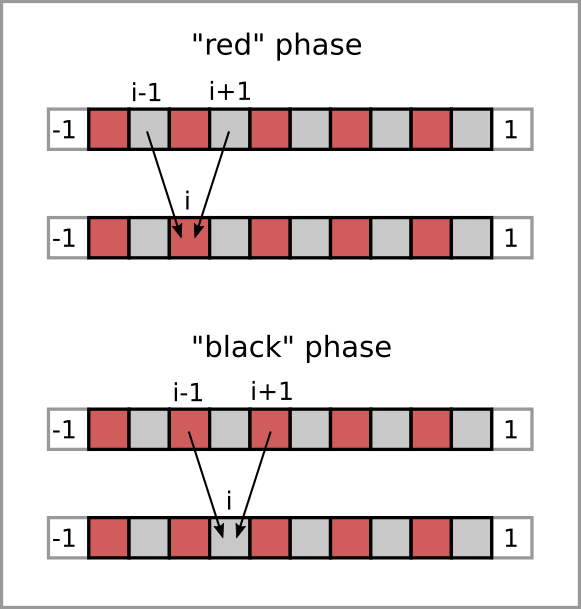
</div>
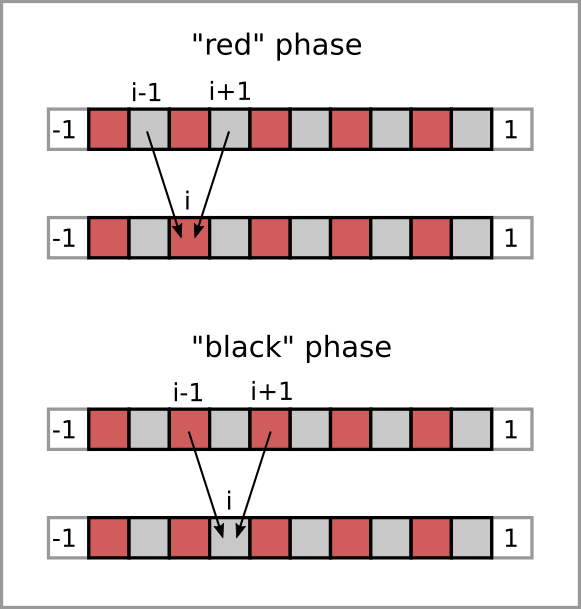

The implementation is given in the following cell. Note that we introduced an extra loop that represent
each one of the two phases.

In [ ]:
function red_black_gauss_seidel(n,niters)
    u = zeros(n+2)
    u[1] = -1
    u[end] = 1
    for t in 1:niters
        for color in (0,1)
            for i in (n+1):-1:2
                if color == mod(i,2)
                    u[i] = 0.5*(u[i-1]+u[i+1])
                end
            end
        end
    end
    u
end

Run the method for several values of `niters`.

In [ ]:
n = 5
niters = 1000
red_black_gauss_seidel(n,niters)

<div class="alert alert-block alert-success">
<b>Question:</b>  Which of the loops in the red-black Gauss-Seidel method are trivially parallelizable?
</div>

```julia
for t in 1:niters
    for color in (0,1)
        for i in (n+1):-1:2
            if color == mod(i,2)
                u[i] = 0.5*(u[i-1]+u[i+1])
            end
        end
    end
end
```

    a) All loops
    b) Loop over t only
    c) Loop over color only
    d) Loop over i only


In [ ]:
answer = "x" # replace x with a, b, c or d
gauss_seidel_2_check(answer)

In [ ]:
uncover = false
gauss_seidel_2_why(uncover)

### Changing an algorithm to make it parallel

Note that the original method (the forward Gauss-Seidel) cannot be parallelized, we needed to modify the method slightly with the red-black ordering in order to create a method that can be parallelized. However the method we parallelized is not equivalent to the original one. This happens in practice in many other applications. An algorithm might be impossible to parallelize and one needs to modify it to exploit parallelism. However, one needs to be careful when modifying the algorithm to not destroy the algorithmic properties of the original one. In this case, we succeeded. The red-black Gauss-Seidel converges as fast (if not faster) than the original forward Gauss-Seidel. However, this is not true in general. There is often a trade-off between the algorithmic properties and how parallelizable is the algorithm.

## MPI implementation

In the last part of this notebook, we consider the implementation of the Jacobi method using MPI. We will consider the 1D version for simplicity.


<div class="alert alert-block alert-info">
<b>Note:</b> The programming model of MPI is generally better suited for data-parallel algorithms like this one than the task-based model provided by Distributed.jl. In any case, one can also implement it using Distributed.jl, but it requires some extra effort to setup the remote channels right for the communication between neighbor processes. 
</div>


We are going to implement the method in a function with the following signature

```julia
    u = jacobi_mpi(n,niters,comm)
```

The signature will be very similar to the sequential function `jacobi`, but there are some important differences:

1. The parallel one takes an MPI communicator object. This allows the user to decide which communicator to use. For instance, `MPI.COMM_WORLD` directly or a duplicate of this one (which is the recommended approach).
2. Function `jacobi_mpi` will be called on multiple MPI ranks. Thus, the values of `n` and `niters` should be the same in all ranks. The caller of this function has to make sure that this is true. Otherwise, the parallel code will not work.
3. The result `u` is NOT the same as the result of the sequential function `jacobi`. It will contained only the local portion of `u` stored at each rank. To recover the same vector as in the sequential case, one needs to gather these pieces in a single rank. We will do this later.

The implementation of the parallel function is given in the following code snipped:

In [ ]:
code1 = quote
    function jacobi_mpi(n,niters,comm)
        # Initialization
        u, u_new = init(n,comm)
        for t in 1:niters
            # Communication
            ghost_exchange!(u,comm)
            # Local computation
            local_update!(u,u_new)
            u, u_new = u_new, u
        end
        return u
    end
end;

In the following cells, we discuss the implementation of the helper functions `init`, `ghost_exchange`, and `local_update`.

### Initialization

Let us start with function `init`.

In [ ]:
code2 = quote
    function init(n,comm)
        nranks = MPI.Comm_size(comm)
        rank = MPI.Comm_rank(comm)
        if mod(n,nranks) != 0
            println("n must be a multiple of nranks")
            MPI.Abort(comm,1)
        end
        load = div(n,nranks)
        u = zeros(load+2)
        if rank == 0
            u[1] = -1
        end
        if rank == nranks-1
            u[end] = 1
        end
        u_new = copy(u)
        u, u_new
    end
end;

This function crates and initializes the vector `u` and the auxiliary vector `u_new` and fills in the boundary values. Note that we are not creating the full arrays like in the sequential case. We are only creating the parts to be managed by the current rank. To this end, we start by computing the number of entries to be updated in this rank, i.e., variable `load`. We have assumed that `n` is a multiple of the number of ranks for simplicity. If this is not the case, we stop the computation with `MPI.Abort`. Note that we are allocating two extra elements in `u` (and `u_new`) for the ghost cells and boundary conditions. The following figure displays the arrays created for `n==9` and `nranks==3` (thus `load == 3`). Note that the first and last elements of the arrays are displayed with gray edges denoting that they are the extra elements allocated for ghost cells or boundary conditions.

<div>
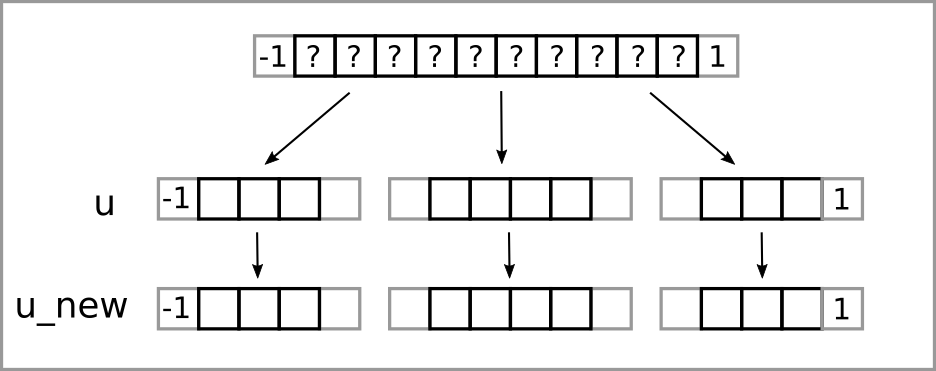
</div>
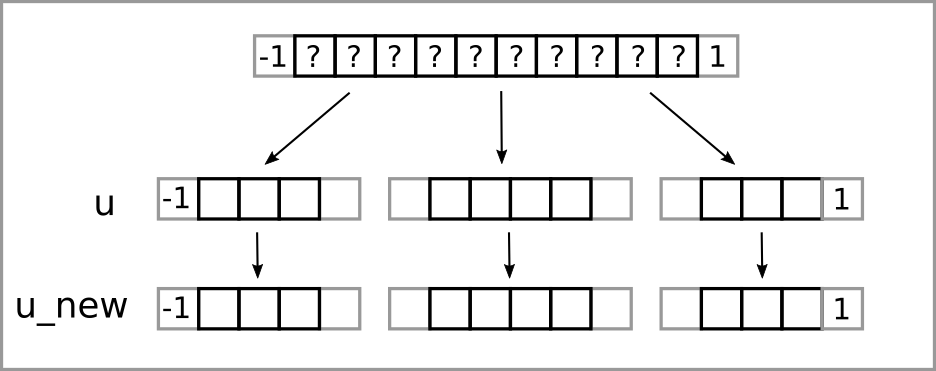

### Communication

Once the working arrays have been created, we can start with the iterations of the Jacobi method. Remember that this is implemented in parallel by updating the ghost cells with data from neighboring processes and then performing the sequential Jacobi update. See figure:

<div>
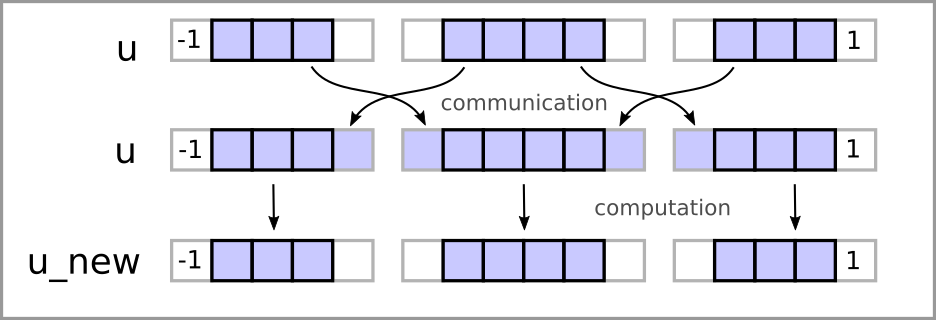
</div>
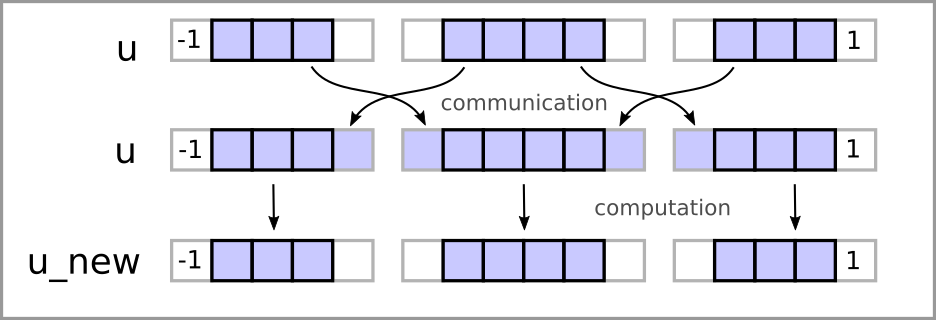

The communication step happens in function `ghost_exchange!`. This one modifies the ghost cells in the input vector `u` by importing data using MPI point-to-point communication. See the following code:

In [ ]:
code3 = quote
    function ghost_exchange!(u,comm)
        load = length(u)-2
        rank = MPI.Comm_rank(comm)
        nranks = MPI.Comm_size(comm)
        if rank != 0
            neig_rank = rank-1
            u_snd = view(u,2:2)
            u_rcv = view(u,1:1)
            dest = neig_rank
            source = neig_rank
            MPI.Sendrecv!(u_snd,u_rcv,comm;dest,source)
        end
        if rank != (nranks-1)
            neig_rank = rank+1
            u_snd = view(u,(load+1):(load+1))
            u_rcv = view(u,(load+2):(load+2))
            dest = neig_rank
            source = neig_rank
            MPI.Sendrecv!(u_snd,u_rcv,comm;dest,source)
        end
    end
end;

Note that we have used `MPI.Sendrecv!` to send and receive values.

<div class="alert alert-block alert-success">
<b>Question:</b>  Is this other implementation based on `MPI.Send` and `MPI.Recv!` correct?
</div>

```julia
    function ghost_exchange!(u,comm)
        load = length(u)-2
        rank = MPI.Comm_rank(comm)
        nranks = MPI.Comm_size(comm)
        if rank != 0
            neig_rank = rank-1
            u_snd = view(u,2:2)
            u_rcv = view(u,1:1)
            dest = neig_rank
            source = neig_rank
            MPI.Send(u_snd,comm;dest)
            MPI.Recv!(u_rcv,comm;source)
        end
        if rank != (nranks-1)
            neig_rank = rank+1
            u_snd = view(u,(load+1):(load+1))
            u_rcv = view(u,(load+2):(load+2))
            dest = neig_rank
            source = neig_rank
            MPI.Send(u_snd,comm;dest)
            MPI.Recv!(u_rcv,comm;source)
        end
    end
```

    a) It is correct.
    b) It is incorrect, but it might provide the right result depending on the MPI implementation.
    c) It is incorrect, and it is guaranteed that it will result in a dead lock.
    d) This implementation does not work when distributing over just a single MPI rank.


In [ ]:
answer = "x" # replace x with a, b, c or d
sndrcv_check(answer)

<div class="alert alert-block alert-success">
<b>Question:</b>  How would you fix the implementation above, while still using `MPI.Send` and `MPI.Recv!` instead of `MPI.Sendrecv!` ?
</div>

Think about the answer. To uncover the the solution run next cell.

In [ ]:
uncover = false
sndrcv_fix_answer(uncover)

### Local computation

Once the ghost cells have the right values, we can perform the Jacobi update locally at each process. This is done in function `local_update!`. Note that here we only update the data *owned* by the current MPI rank, i.e. we do not modify the ghost values. There is no need to modify the ghost values since they will updated by another rank. In the code, this is reflected in the loop over `i`. We do not visit the first nor the last entry in `u_new`.

In [ ]:
code4 = quote
    function local_update!(u,u_new)
        load = length(u)-2
        for i in 2:(load+1)
            u_new[i] = 0.5*(u[i-1]+u[i+1])
        end
    end
end;

### Running the code

Let us put all pieces together and run the code. If not done yet, install MPI.

In [ ]:
] add MPI

The following cells includes all previous code snippets into a final one. We are eventually calling function `jacobi_mpi` and showing the result vector `u`. Run the following code for 1 MPI rank, then for 2 and 3 MPI ranks. Look into the values of `u`. Does it make sense?

In [ ]:
using MPI
code = quote
    using MPI
    MPI.Init()
    $code1
    $code2
    $code3
    $code4
    n = 9
    niters = 200
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    u = jacobi_mpi(n,niters,comm)
    @show u
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

### Checking the result

Checking the result visually is not enough in general. To check the parallel implementation we want to compare it against the sequential implementation. However, how can we compare the sequential and the parallel result? The parallel version gives a distributed vector. We cannot compare this one directly with the result of the sequential function. A possible solution is to gather all the pieces of the parallel result in a single rank and compare there against the parallel implementation.


The following function gather the distributed vector in rank 0.

In [ ]:
code5 = quote
    function gather_final_result(u,comm)
        load = length(u)-2
        rank = MPI.Comm_rank(comm)
        if rank !=0
            # If I am not rank 0
            # I send my own data to rank 0
            u_snd = view(u,2:(load+1))
            MPI.Send(u_snd,comm,dest=0)
            u_root = zeros(0) # This will nevel be used
        else
            # If I am rank 0
            nranks = MPI.Comm_size(comm)
            n = load*nranks
            u_root = zeros(n+2)
            # Set boundary
            u_root[1] = -1
            u_root[end] = 1
            # Set data for rank 0
            lb = 2
            ub = load+1
            u_root[lb:ub] = view(u,lb:ub)
            # Receive and set data from other ranks
            for other_rank in 1:(nranks-1)
                lb += load
                ub += load
                u_rcv = view(u_root,lb:ub)
                MPI.Recv!(u_rcv,comm;source=other_rank)
            end
        end
        # NB onle the root (rank 0) will
        # contain meaningfull data
        return u_root
    end
end;

Run the following cell to see the result. Is the result as expected?

In [ ]:
code = quote
    using MPI
    MPI.Init()
    $code1
    $code2
    $code3
    $code4
    $code5
    n = 9
    niters = 200
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    u = jacobi_mpi(n,niters,comm)
    u_root = gather_final_result(u,comm)
    @show u_root
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

Now that we have collected the parallel vector into a single array, we can compare it against the sequential implementation. This is done in the following cells.

In [ ]:
code6 = quote
    function jacobi(n,niters)
        u = zeros(n+2)
        u[1] = -1
        u[end] = 1
        u_new = copy(u)
        for t in 1:niters
            for i in 2:(n+1)
                u_new[i] = 0.5*(u[i-1]+u[i+1])
            end
            u, u_new = u_new, u
        end
        u
    end
end;

In [ ]:
code = quote
    using MPI
    MPI.Init()
    $code1
    $code2
    $code3
    $code4
    $code5
    $code6
    n = 12
    niters = 100
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    u = jacobi_mpi(n,niters,comm)
    u_root = gather_final_result(u,comm)
    rank = MPI.Comm_rank(comm)
    if rank == 0
        # Compare agains serial
        u_seq = jacobi(n,niters)
        if isapprox(u_root,u_seq)
            println("Test passed 🥳")
        else
            println("Test failed")
        end
    end
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

## Latency hiding

We have now a correct parallel implementation. But. can our implementation above be improved? Note that we only need communications to update the values at the boundary of the portion owned by each process. The other values (the one in green in the figure below) can be updated without communications. This provides the opportunity of overlapping the computation of the interior values (green cells in the figure) with the communication of the ghost values. This technique is called latency hiding, since we are hiding communication latency by overlapping it with computation that we need to do anyway. The actual implementation is left as an exercise (see Exercise 1).

<div>
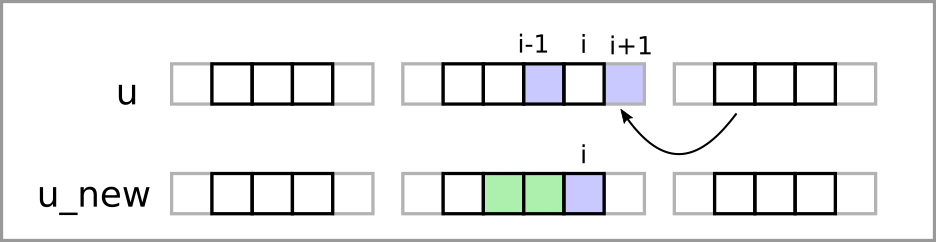
</div>

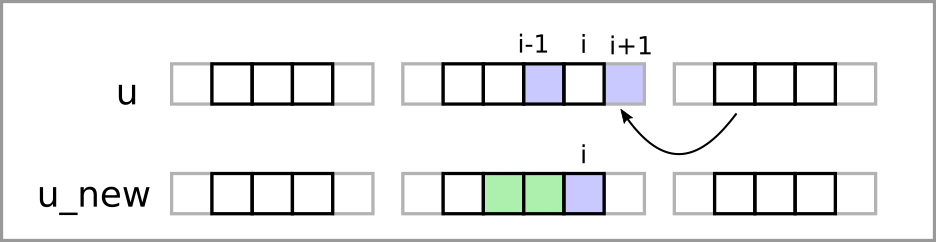

<div class="alert alert-block alert-success">
<b>Question:</b>  Which MPI directives would you use to implement latency hiding in the communication the ghost values?
</div>

    a) MPI_Send and MPI_Recv
    b) MPI_Bsend and MPI_Recv
    c) MPI_Isend and MPI_Irecv 
    d) MPI_Sendrecv

In [ ]:
answer = "x" # replace x with a, b, c or d
lh_check(answer)

## Conclusion

- We learned how to parallelize the Jacobi method efficiently.
- Using block partitions the communication overhead is small if the problem size is larger than the number of processors.
- In addition, one can use latency hiding to further reduce the overhead caused by communication.
- Both are not true if we use cyclic data partitions.
- Gauss-Seidel is a simple variation of Jacobi but is much more challenging to parallelize.
- One needs to consider a special order (red-black) when updating the values to parallelize the method.
- We learned how to implement a 1D Jacobi method with MPI.
- Once needs to be careful when using blocking directives to avoid dead locks.

## Exercises

### Exercise 1

The following code implements the 1D Jacobi method studied in this notebook, but using non-blocking sends and receives. Modify this code so that you overlap the communication of the ghost values with local computations as explained above in the section "latency hiding". You only need to modify function `jacobi_mpi_latency_hiding`. Copy the code below to a file called `ex1.jl`. Modify the file (e.g. with vscode).  Run it from the Julia REPL using the `run` function as explained in the [Getting Started tutorial](https://www.francescverdugo.com/XM_40017/dev/getting_started_with_julia/#Running-MPI-code).


```julia
# file ex1.jl (begin)

using MPI
MPI.Init()

function jacobi_mpi_latency_hiding(n,niters,comm)
    u, u_new = init(n,comm)
    load = length(u)-2
    rank = MPI.Comm_rank(comm)
    nranks = MPI.Comm_size(comm)
    nreqs = 2*((rank != 0) + (rank != (nranks-1)))
    reqs = MPI.MultiRequest(nreqs)
    for t in 1:niters
        ireq = 0
        if rank != 0
            neig_rank = rank-1
            u_snd = view(u,2:2)
            u_rcv = view(u,1:1)
            dest = neig_rank
            source = neig_rank
            ireq += 1
            MPI.Isend(u_snd,comm,reqs[ireq];dest)
            ireq += 1
            MPI.Irecv!(u_rcv,comm,reqs[ireq];source)
        end
        if rank != (nranks-1)
            neig_rank = rank+1
            u_snd = view(u,(load+1):(load+1))
            u_rcv = view(u,(load+2):(load+2))
            dest = neig_rank
            source = neig_rank
            ireq += 1
            MPI.Isend(u_snd,comm,reqs[ireq];dest)
            ireq += 1
            MPI.Irecv!(u_rcv,comm,reqs[ireq];source)
        end
        MPI.Waitall(reqs)
        for i in 2:load+1
            u_new[i] = 0.5*(u[i-1]+u[i+1])
        end
        u, u_new = u_new, u
    end
    return u
end

function init(n,comm)
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    if mod(n,nranks) != 0
        println("n must be a multiple of nranks")
        MPI.Abort(comm,1)
    end
    load = div(n,nranks)
    u = zeros(load+2)
    if rank == 0
        u[1] = -1
    end
    if rank == nranks-1
        u[end] = 1
    end
    u_new = copy(u)
    u, u_new
end

function gather_final_result(u,comm)
    load = length(u)-2
    rank = MPI.Comm_rank(comm)
    if rank !=0
        u_snd = view(u,2:(load+1))
        MPI.Send(u_snd,comm,dest=0)
        u_root = zeros(0)
    else
        nranks = MPI.Comm_size(comm)
        n = load*nranks
        u_root = zeros(n+2)
        u_root[1] = -1
        u_root[end] = 1
        lb = 2
        ub = load+1
        u_root[lb:ub] = view(u,lb:ub)
        for other_rank in 1:(nranks-1)
            lb += load
            ub += load
            u_rcv = view(u_root,lb:ub)
            MPI.Recv!(u_rcv,comm;source=other_rank)
        end
    end
    return u_root
end

function jacobi(n,niters)
    u = zeros(n+2)
    u[1] = -1
    u[end] = 1
    u_new = copy(u)
    for t in 1:niters
        for i in 2:(n+1)
            u_new[i] = 0.5*(u[i-1]+u[i+1])
        end
        u, u_new = u_new, u
    end
    u
end

n = 12
niters = 100
comm = MPI.Comm_dup(MPI.COMM_WORLD)
u = jacobi_mpi_latency_hiding(n,niters,comm)
u_root = gather_final_result(u,comm)
rank = MPI.Comm_rank(comm)
if rank == 0
    u_seq = jacobi(n,niters)
    if isapprox(u_root,u_seq)
        println("Test passed 🥳")
    else
        println("Test failed 😢")
    end
end

# file ex1.jl (end)
```

### Exercise 2

In the parallel implementation of the Jacobi method, we assumed that the method runs for a given number of iterations. In function, `jacobi_with_tol` at the beginning of the notebook shows how the Jacobi iterations can be stopped when the difference between iterations is small. Implement a parallel version of this function. Start with the code in Exercise 1 and add the stopping criterion implemented in `jacobi_with_tol`. Use a text editor and the Julia REPL. Do not try to implement the code in a notebook.

# License



This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.